# Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1)

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
arena_members = pd.read_csv('data/data_arena_members.csv')
arenas = pd.read_csv('data/data_arenas.csv')

In [3]:
arena_members = arena_members.merge(arenas[['arena_id', 'battle_type_id', 'battle_level_id', 'winner_team_id']], how='left', on='arena_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,2790,15,20,16533,0,0,0,1,9,2
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,829,15,10,4468,0,0,0,1,9,2
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,240,15,10,5419,1030,0,0,1,9,2
3,2018-09-16,7N1T221ccNyadyccT,202,ca1a2y2cy,1,0,0,0,529,330,...,343,15,10,18874,0,0,0,1,9,2
4,2018-09-16,7N1T221ccNyadyccT,202,caca47y7a,2,0,0,0,10257,379,...,3190,15,20,10470,840,0,0,1,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427925,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,494,15,10,26773,1560,0,0,1,8,1
2427926,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1415,15,10,3869,1790,0,0,1,8,1
2427927,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,380,15,10,58261,390,0,0,1,8,1
2427928,2018-10-10,cTacc2711d4da4y,202,c44d7NNNa,2,500138173,0,0,15649,336,...,337,15,10,27681,0,0,0,1,8,1


# Utils

In [4]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_network(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_network_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
        
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
    plt.ylim([0,1])
    plt.legend()

    plt.show()

# Catalog cleaning

In [5]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows. ({100 * (1 - len(catalog) / N)} %)')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows. ({100 * len(removed_tanks) / (len(removed_tanks) + len(catalog))} %)')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows. (0.7882882882882858 %)
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows. (1.0215664018161208 %)
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows. (11.238532110091748 %)
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows. (2.5839793281653756 %)
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows. (0.13262599469495706 %)

Totally removed 135 rows. (15.202702702702704 %)


In [6]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

classEncoder = LabelEncoder()
catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


In [7]:
N0 = len(catalog)

print(f'Catalog shape: {catalog.shape}\n')

N = len(catalog)
print('[REMOVING DUPLICATES...]', end='   ')
catalog = catalog.dropna()
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

N = len(catalog)
print('[REMOVING NAN...]', end='   ')
catalog = catalog[~catalog.isna()]
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

print(f'\nTotally removed {N0 - len(catalog)} rows. ({100 * (1 - len(catalog) / N0)} %)\n')

catalog.info()

Catalog shape: (753, 6)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   item_cd            753 non-null    category
 1   item_class         753 non-null    int32   
 2   item_price_credit  753 non-null    int64   
 3   item_price_gold    753 non-null    int64   
 4   item_level         753 non-null    int64   
 5   crew_size          753 non-null    int64   
dtypes: category(1), int32(1), int64(4)
memory usage: 59.7 KB


In [8]:
s1 = set(removed_tanks['item_cd'])
s2 = set(arena_members['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{13889, 58625, 61697, 65281, 9297, 6225}


# Catalog visualizing

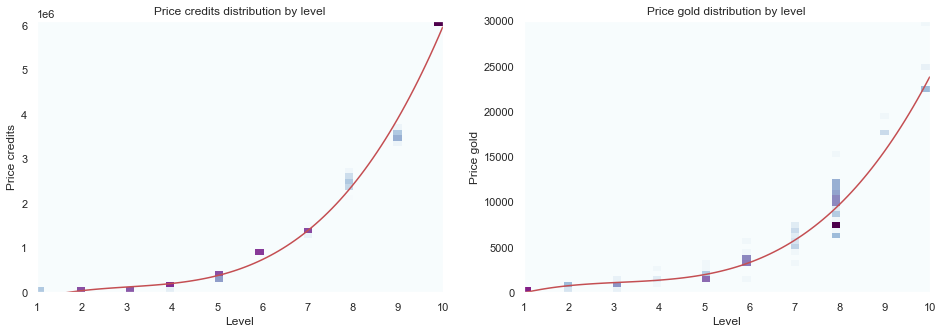

In [9]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

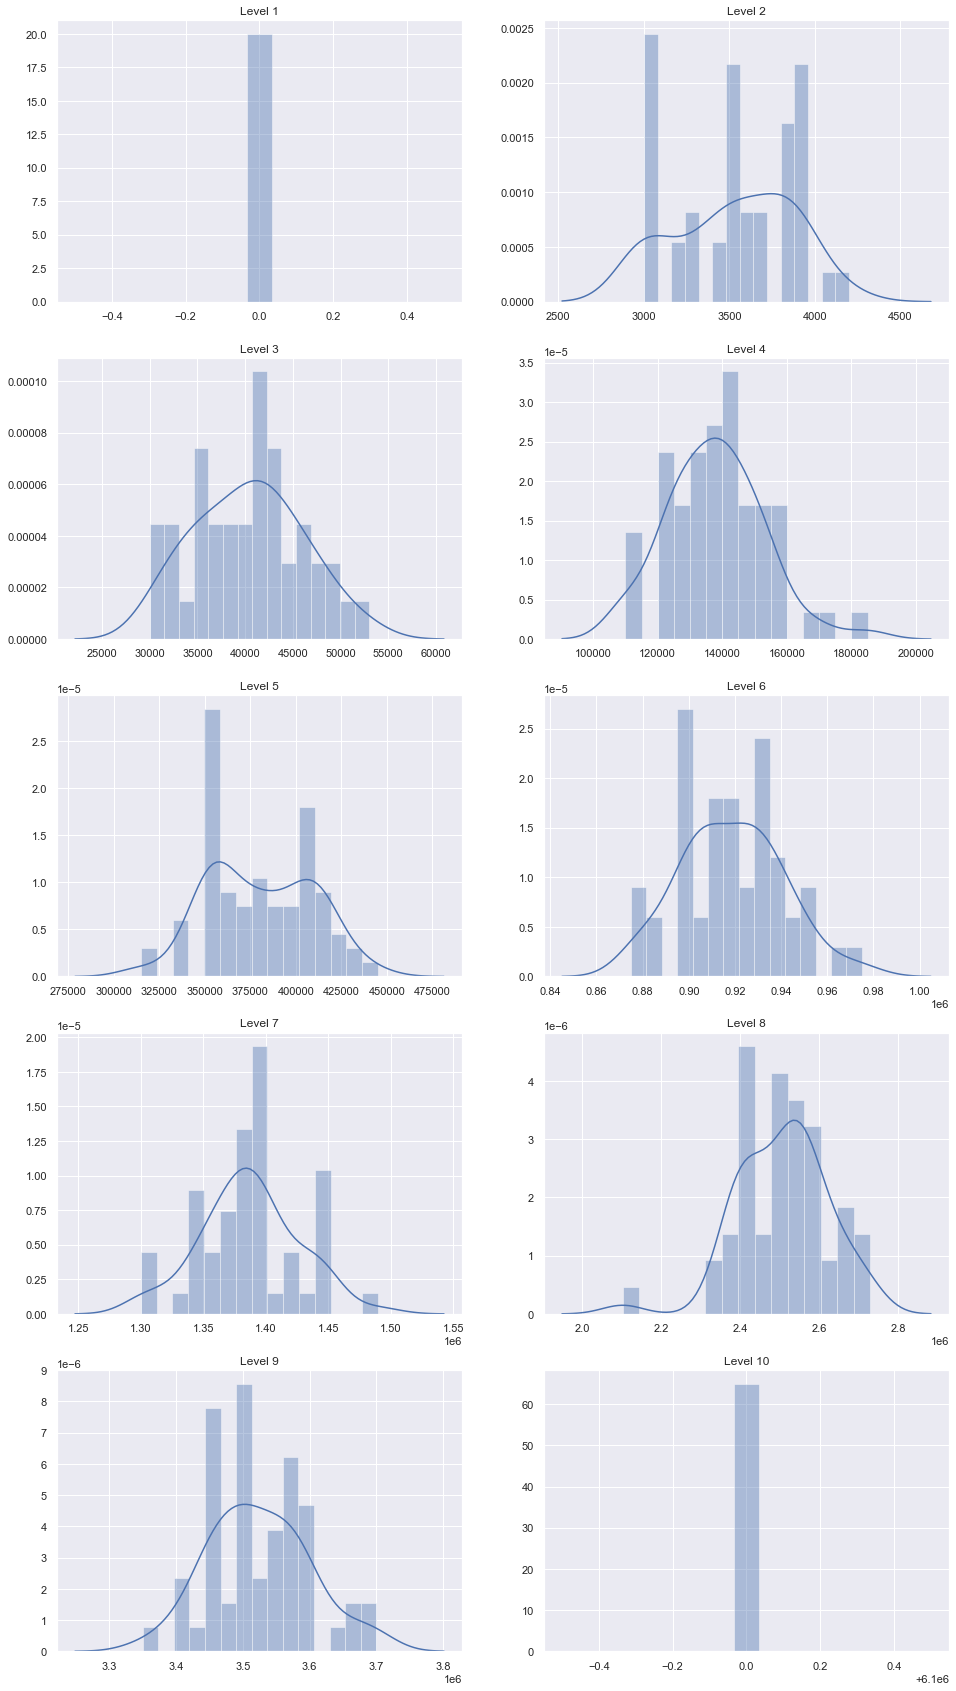

In [10]:
price_ditributions(creds_catalog, price='creds')

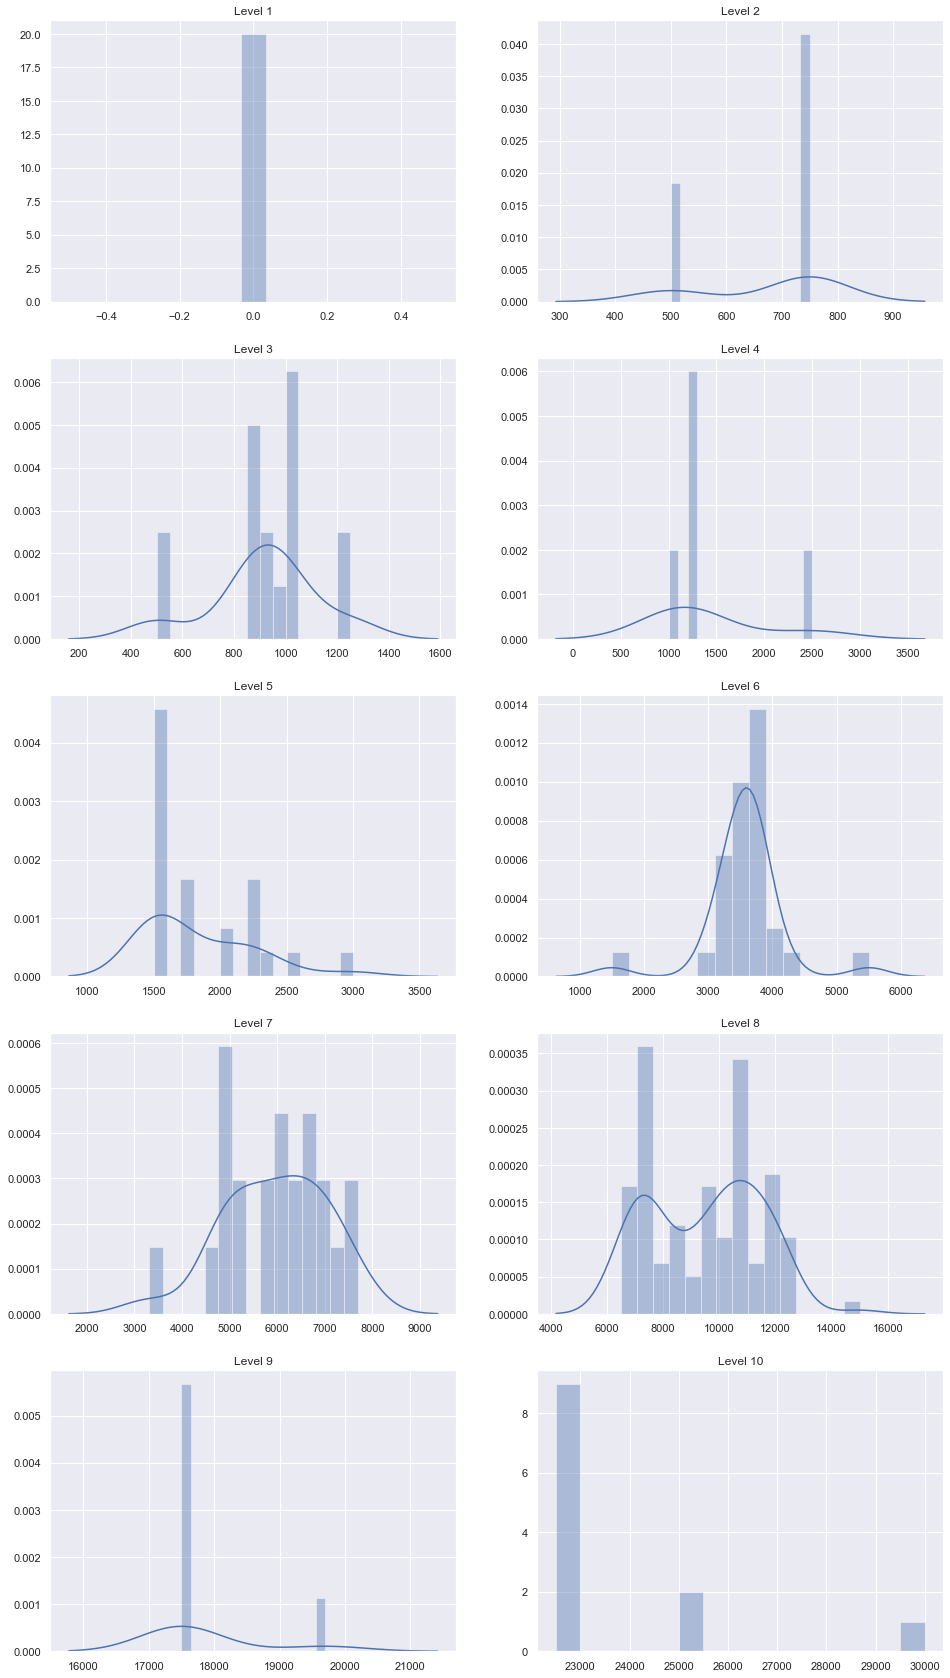

In [11]:
price_ditributions(gold_catalog, price='gold')

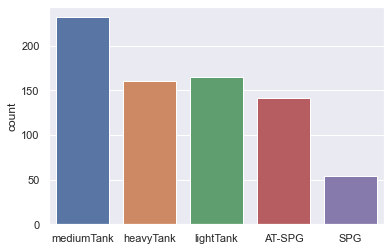

In [12]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

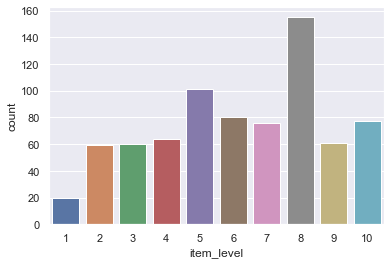

In [13]:
sns.countplot(catalog['item_level']);

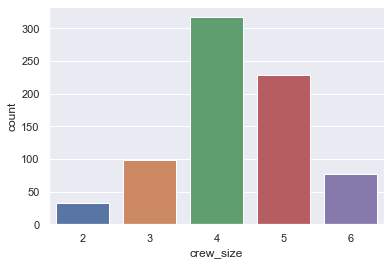

In [14]:
sns.countplot(catalog['crew_size']);

# Arenas data cleaning

In [15]:
N0 = len(arena_members)

masks = [
    ('sync with catalog: vehicle_type_cd not in removed_ids', \
    ~arena_members['vehicle_type_cd'].isin(removed_ids))
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[SYNC WITH CATALOG: VEHICLE_TYPE_CD NOT IN REMOVED_IDS]: removed 687 rows. (0.028295708690118104 %)

Totally removed 687 rows. (0.028295708690118104 %)


In [16]:
for feature in ['clan_db_id', 'is_prebattle_creator']:
    arena_members[feature] = pd.Categorical(arena_members[feature])

arena_members['dt'] = pd.to_datetime(arena_members['dt'])

In [17]:
N0 = len(arena_members)

print(f'Arena members shape: {arena_members.shape}\n')

N = len(arena_members)
print('[REMOVING DUPLICATES...]', end='   ')
arena_members = arena_members.dropna()
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

N = len(arena_members)
print('[REMOVING NAN...]', end='   ')
arena_members = arena_members[~arena_members.isna()]
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

arena_members.info()

Arena members shape: (2427243, 38)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2427243 entries, 0 to 2427242
Data columns (total 38 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   dt                        datetime64[ns]
 1   arena_id                  object        
 2   periphery_id              int64         
 3   account_db_id             object        
 4   team_id                   int64         
 5   clan_db_id                category      
 6   prebattle_id              int64         
 7   is_prebattle_creator      category      
 8   vehicle_type_cd           int64         
 9   life_time_sec             int64         
 10  shots                     int64         
 11  hits                      int64         
 12  he_hits                   int64         
 13  pierced                   int64   

# Creating normed by time features

In [18]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0

normalize_feature = np.vectorize(normalize_feature)

In [19]:
arena_members['total_damage_dealt'] = arena_members['damage_dealt'] + arena_members['damage_assisted_radio'] + \
                                      arena_members['damage_assisted_stun'] + arena_members['damage_assisted_track']

arena_members['life_time_min'] = arena_members['life_time_sec'] / 60

# Restoring winrates

In [20]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0     
    return winner

arena_members['is_alive'] = arena_members['remained_hp'] > 0

N = len(arena_members)
print('[FILTERING DATA FOR FULL 15x15 TEAMS...]', end='  ')
arena_members = arena_members[arena_members.groupby('arena_id')['account_db_id'].transform('count') == 30]
arena_members.index = np.arange(len(arena_members))
print(f'[FILTERED]: removed {N - len(arena_members)} rows!')

print('[GROUPING BATTLES AND TEAMS...]', end='  ')
battles = arena_members.groupby(['arena_id', 'team_id'])
print(f'[GROUPED BATTLES AND TEAMS]: There are {sum(battles["account_db_id"].count() != 15)} not full teams!')

print('[CALCULATING STATS...]', end='  ')
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
print(f'[CALCULATED STATS]: There are {len(battles) // 2} restored battles!')
    
print('[CALCULATING WINNERS...]', end='  ')
info_df['winner_team_id_my'] = info_df.apply(calc_winner, axis=1)
print('[CALCULATED WINNERS]')

print('[JOINING...]', end='  ')
info_df.reset_index(inplace=True)
arena_members = arena_members.merge(info_df[['index', 'winner_team_id_my']], how='left', left_on='arena_id', right_on='index')
arena_members.drop(columns=['index'], inplace=True, axis=1)
print('[JOINED]')

arena_members['is_winner'] = arena_members['team_id'] == arena_members['winner_team_id']
arena_members['is_winner_my'] = arena_members['team_id'] == arena_members['winner_team_id_my']

[FILTERING DATA FOR FULL 15x15 TEAMS...]  [FILTERED]: removed 52443 rows!
[GROUPING BATTLES AND TEAMS...]  [GROUPED BATTLES AND TEAMS]: There are 0 not full teams!
[CALCULATING STATS...]  [CALCULATED STATS]: There are 79160 restored battles!
[CALCULATING WINNERS...]  [CALCULATED WINNERS]
[JOINING...]  [JOINED]


In [21]:
print(f"Our algorithm accuracy = {100 - 100 * abs(arena_members['is_winner'].sum() - arena_members['is_winner_my'].sum()) / len(arena_members)} %")

Our algorithm accuracy = 99.7043961596766 %


Critical battles number = 3.0


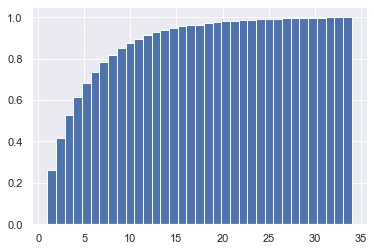

In [22]:
player_battles = arena_members.groupby('account_db_id')['account_db_id'].count()

battles_critical = np.percentile(player_battles, 45)
print(f'Critical battles number = {battles_critical}')

plt.hist(player_battles[player_battles < 35], bins=35, density=True, cumulative=True)
plt.show()

In [23]:
N = len(arena_members)

print('[FILTERING BY CRITICAL BATTLES NUMBER...]', end='   ')
arena_members = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') > battles_critical]
print(f'[FILTERED: removed {N - len(arena_members)} rows.] ({100 - 100 * len(arena_members) / N} %)')

arena_members

[FILTERING BY CRITICAL BATTLES NUMBER...]   [FILTERED: removed 412911 rows.] (17.387190500252657 %)


,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_alive,winner_team_id_my,is_winner,is_winner_my
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,0,1,9,2,3075,6.316667,True,2,True,True
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,0,1,9,2,2607,6.316667,True,2,True,True
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,0,1,9,2,850,5.800000,False,2,False,False
5,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,194,1,9,2,1039,4.916667,False,2,False,False
7,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,1343,1,9,2,2401,5.616667,False,2,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374794,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,0,1,8,1,2076,8.483333,False,1,False,False
2374795,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,0,1,8,1,1377,2.983333,False,1,False,False
2374796,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,0,1,8,1,2619,5.100000,False,1,True,True
2374797,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,0,1,8,1,1011,5.566667,False,1,False,False


In [24]:
players_for_train = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') >= 10]
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                                    'remained_hp' : 'mean',
                                                                    'kills_made' : 'mean',
                                                                    'total_damage_dealt' : 'mean',
                                                                    'damaged' : 'mean',
                                                                    'pierced' : 'mean',
                                                                    'original_credits' : 'mean',
                                                                    'hits' : 'mean',
                                                                    'life_time_min' : 'mean',
                                                                    'damage_assisted_track' : 'mean',
                                                                    'spotted' : 'mean',
                                                                    'pierced_received' : 'mean',
                                                                    'is_winner' : lambda g: sum(g) / len(g)})

features = ['mean_original_xp', 'mean_remained_hp', 'mean_kills_made', 'mean_total_damage_dealt',
                            'mean_damaged', 'mean_pierced', 'mean_original_credits', 'mean_hits',
                            'mean_life_time_min', 'mean_damage_assisted_track', 'mean_spotted', 'mean_pierced_received']
target = ['player_winrate']
players_for_train.columns = features + target

players_for_train

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21117yd2,1258.700000,242.200000,0.500000,1830.800000,3.500000,5.000000,29542.100000,8.000000,4.896667,215.400000,0.900000,4.200000,0.500000
c2111Ncyd,1456.937500,174.229167,1.062500,2285.625000,3.937500,6.645833,70518.937500,9.583333,4.234722,112.916667,1.583333,3.645833,0.583333
c2111TTa7,267.923077,166.769231,0.307692,469.692308,1.461538,1.923077,7834.153846,4.153846,5.701282,0.000000,0.307692,2.615385,0.230769
c2111ad1c,905.571429,76.571429,0.571429,1051.642857,2.714286,3.357143,16515.785714,5.142857,4.694048,20.000000,2.000000,4.714286,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyydN4N,717.600000,25.600000,0.400000,792.800000,2.100000,2.200000,19133.900000,4.000000,4.303333,82.000000,0.300000,4.300000,0.400000
cyyyydyNa,1348.230769,61.615385,0.461538,958.923077,1.692308,2.076923,39881.307692,2.846154,2.833333,57.307692,2.076923,4.000000,0.461538
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630


In [25]:
players_feature_scaler, players_winrate_scaler = StandardScaler(), StandardScaler()

Xn = players_feature_scaler.fit_transform(players_for_train[features])
Yn = players_winrate_scaler.fit_transform(players_for_train[target])

pcaWinrate = PCA(n_components=0.95)
pcaWinrate_components = pcaWinrate.fit_transform(Xn)

numWinrateComponents = pcaWinrate_components.shape[1]

model = GradientBoostingRegressor(n_estimators=400, max_depth=8)
model.fit(Xn, Yn.reshape(len(Yn),))

preds = model.predict(Xn)

#plt.scatter(Xn, Yn, color='gray')
#plt.scatter(Xn, preds, color='red')
#plt.show()

mean_squared_error(Yn, preds)

0.32229165693954087

In [26]:
players_data = arena_members.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                           'remained_hp' : 'mean',
                                                           'kills_made' : 'mean',
                                                           'total_damage_dealt' : 'mean',
                                                           'damaged' : 'mean',
                                                           'pierced' : 'mean',
                                                           'original_credits' : 'mean',
                                                           'hits' : 'mean',
                                                           'life_time_min' : 'mean',
                                                           'damage_assisted_track' : 'mean',
                                                           'spotted' : 'mean',
                                                           'pierced_received' : 'mean',
                                                           'is_winner' : lambda g: sum(g) / len(g)})
players_data.columns = features + target

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21112TT1,865.500000,-0.500000,0.666667,1617.000000,2.166667,5.166667,20181.000000,6.000000,3.272222,180.500000,1.500000,5.333333,0.500000
c211147T2,1718.200000,463.200000,1.000000,2222.800000,3.400000,5.600000,44238.600000,7.600000,5.796667,0.000000,0.800000,3.200000,0.600000
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21114TaT,717.250000,102.125000,1.375000,2784.375000,5.375000,6.250000,29431.750000,9.500000,5.439583,62.375000,1.375000,4.375000,0.500000
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455
cyyyyy42N,924.400000,0.000000,0.200000,1363.200000,2.200000,2.600000,15529.800000,4.400000,3.533333,0.000000,2.000000,5.000000,0.400000
cyyyyyT74,914.875000,239.625000,0.375000,1093.125000,2.625000,2.750000,24891.875000,4.250000,5.895833,45.875000,0.125000,3.500000,0.500000


In [27]:
players_features_normed = players_feature_scaler.transform(players_data[features])
winrateComponents = pcaWinrate.transform(players_features_normed)[:, numWinrateComponents - 1]

players_winrate_normed = model.predict(players_features_normed)
players_data['player_winrate_ML'] = players_winrate_scaler.inverse_transform(players_winrate_normed)

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate,player_winrate_ML
account_db_id,,,,,,,,,,,,,,
c21112TT1,865.500000,-0.500000,0.666667,1617.000000,2.166667,5.166667,20181.000000,6.000000,3.272222,180.500000,1.500000,5.333333,0.500000,0.433365
c211147T2,1718.200000,463.200000,1.000000,2222.800000,3.400000,5.600000,44238.600000,7.600000,5.796667,0.000000,0.800000,3.200000,0.600000,0.624193
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000,0.541301
c21114TaT,717.250000,102.125000,1.375000,2784.375000,5.375000,6.250000,29431.750000,9.500000,5.439583,62.375000,1.375000,4.375000,0.500000,0.395807
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714,0.456883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455,0.524734
cyyyyy42N,924.400000,0.000000,0.200000,1363.200000,2.200000,2.600000,15529.800000,4.400000,3.533333,0.000000,2.000000,5.000000,0.400000,0.487739
cyyyyyT74,914.875000,239.625000,0.375000,1093.125000,2.625000,2.750000,24891.875000,4.250000,5.895833,45.875000,0.125000,3.500000,0.500000,0.459664


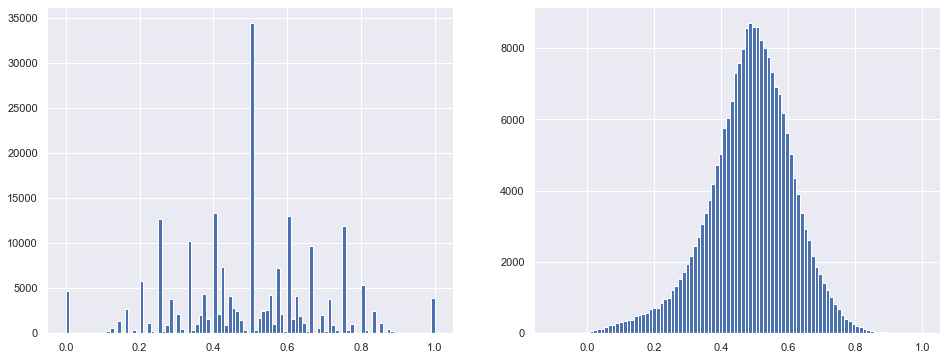

0.485590058537318

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(players_data['player_winrate'], bins=100)
axes[1].hist(players_data['player_winrate_ML'], bins=100)
plt.show()

players_data['player_winrate_ML'].mean()

In [29]:
arena_members = arena_members.merge(players_data[['player_winrate_ML']], how='left', on='account_db_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_alive,winner_team_id_my,is_winner,is_winner_my,player_winrate_ML
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,1,9,2,3075,6.316667,True,2,True,True,0.631809
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,1,9,2,2607,6.316667,True,2,True,True,0.485616
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,1,9,2,850,5.800000,False,2,False,False,0.427052
3,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,1,9,2,1039,4.916667,False,2,False,False,0.146572
4,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,1,9,2,2401,5.616667,False,2,True,True,0.420529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961884,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,1,8,1,2076,8.483333,False,1,False,False,0.406729
1961885,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,1,8,1,1377,2.983333,False,1,False,False,0.432964
1961886,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1,8,1,2619,5.100000,False,1,True,True,0.632388
1961887,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,1,8,1,1011,5.566667,False,1,False,False,0.604939


In [30]:
N0 = len(arena_members)

masks = [
    ('cleaning by tank battles: vehicle_type_cd.grouped.count >= 100', \
    arena_members.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') >= 100)
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[CLEANING BY TANK BATTLES: VEHICLE_TYPE_CD.GROUPED.COUNT >= 100]: removed 1958 rows. (0.09980177267928658 %)

Totally removed 1958 rows. (0.09980177267928658 %)


In [31]:
tanks_data = arena_members.groupby('vehicle_type_cd').agg({'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['tank_winrate']

tanks_data

,tank_winrate
vehicle_type_cd,
49,0.504088
145,0.493056
273,0.463415
305,0.518851
513,0.507962
...,...
64065,0.504362
64273,0.474610
64561,0.505074


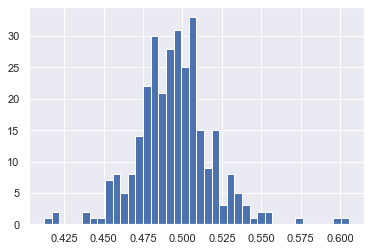

0.4948317646827781

In [32]:
plt.hist(tanks_data['tank_winrate'], bins=40)
plt.show()

tanks_data['tank_winrate'].mean()

In [33]:
arena_members = arena_members.merge(tanks_data[['tank_winrate']], how='left', on='vehicle_type_cd')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_alive,winner_team_id_my,is_winner,is_winner_my,player_winrate_ML,tank_winrate
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,9,2,3075,6.316667,True,2,True,True,0.631809,0.505757
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,9,2,2607,6.316667,True,2,True,True,0.485616,0.493922
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,9,2,850,5.800000,False,2,False,False,0.427052,0.513476
3,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,9,2,1039,4.916667,False,2,False,False,0.146572,0.505757
4,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,9,2,2401,5.616667,False,2,True,True,0.420529,0.506595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,8,1,2076,8.483333,False,1,False,False,0.406729,0.497194
1959927,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,8,1,1377,2.983333,False,1,False,False,0.432964,0.495916
1959928,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,8,1,2619,5.100000,False,1,True,True,0.632388,0.495201
1959929,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,8,1,1011,5.566667,False,1,False,False,0.604939,0.519704


In [34]:
arena_members.drop(columns=['dt', 'periphery_id', 'team_id', 'clan_db_id', 'prebattle_id', 'is_prebattle_creator',
                            'life_time_sec', 'shots', 'hits', 'he_hits', 'pierced', 'mileage_meter',
                            'premium_xp_factor', 'daily_xp_factor', 'battle_num', 'booster_bonus_credits', 'booster_bonus_xp',
                            'remained_hp', 'is_alive', 'winner_team_id', 'winner_team_id_my', 'is_winner', 'is_winner_my'], inplace=True, axis=1)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,kills_made,original_credits,original_xp,damage_blocked_by_armor,battle_type_id,battle_level_id,total_damage_dealt,life_time_min,player_winrate_ML,tank_winrate
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,2,35286,2790,0,1,9,3075,6.316667,0.631809,0.505757
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,1,26896,829,0,1,9,2607,6.316667,0.485616,0.493922
2,7N1T221ccNyadyccT,ca7N4y2y1,3873,850,0,0,0,1250,8,4,...,0,11202,240,1030,1,9,850,5.800000,0.427052,0.513476
3,7N1T221ccNyadyccT,cd1T171cy,7457,618,0,421,0,400,2,0,...,0,9226,388,0,1,9,1039,4.916667,0.146572,0.505757
4,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,2,36788,2686,1310,1,9,2401,5.616667,0.420529,0.506595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,1,51467,712,0,1,8,2076,8.483333,0.406729,0.497194
1959927,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0,54366,494,1560,1,8,1377,2.983333,0.432964,0.495916
1959928,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,1,73469,1415,1790,1,8,2619,5.100000,0.632388,0.495201
1959929,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,0,20699,380,390,1,8,1011,5.566667,0.604939,0.519704


# Creating new features

In [35]:
f = arena_members.groupby(['vehicle_type_cd', 'account_db_id'])[['original_credits',
                                                                 'damage_dealt',
                                                                 'damage_assisted_radio',
                                                                 'damage_assisted_track',
                                                                 'damage_blocked_by_armor',
                                                                 'player_winrate_ML']].mean()

f['normed_damage_dealt'] = (1 - f['player_winrate_ML']) * f['damage_dealt']
f['normed_damage_assisted_radio'] = (1 - f['player_winrate_ML']) * f['damage_assisted_radio']
f['normed_damage_assisted_track'] = (1 - f['player_winrate_ML']) * f['damage_assisted_track']
f['normed_damage_blocked_by_armor'] = (1 - f['player_winrate_ML']) * f['damage_blocked_by_armor']

f = f.groupby(level=0)[['original_credits', 'normed_damage_dealt', 'normed_damage_assisted_radio',
                        'normed_damage_assisted_track', 'normed_damage_blocked_by_armor']].mean()
f = f.rename(columns={'original_credits': 'mean_original_credits'})
f

,mean_original_credits,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
vehicle_type_cd,,,,,
49,51220.040495,479.959688,219.826829,40.741581,230.241584
145,21582.319444,227.203591,119.428428,15.850074,71.171927
273,19250.403621,341.068933,8.992474,19.723632,0.365920
305,33862.425736,289.987615,308.394343,20.457760,11.882486
513,17588.710064,339.511268,116.650466,26.931846,142.440521
...,...,...,...,...,...
64065,45455.173292,480.083281,176.867489,39.023648,111.012978
64273,40430.156189,404.101210,189.294783,31.075164,65.372967
64561,46620.227286,473.663218,169.945646,33.925283,539.696188


In [36]:
arena_members = arena_members.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
arena_members.drop(['item_cd'], axis=1, inplace=True)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,battle_level_id,total_damage_dealt,life_time_min,player_winrate_ML,tank_winrate,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,9,3075,6.316667,0.631809,0.505757,1,2700000,0,8,6
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,9,2607,6.316667,0.485616,0.493922,2,2568500,0,8,4
2,7N1T221ccNyadyccT,ca7N4y2y1,3873,850,0,0,0,1250,8,4,...,9,850,5.800000,0.427052,0.513476,2,1450300,0,7,6
3,7N1T221ccNyadyccT,cd1T171cy,7457,618,0,421,0,400,2,0,...,9,1039,4.916667,0.146572,0.505757,1,2700000,0,8,6
4,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,9,2401,5.616667,0.420529,0.506595,2,2600000,0,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,8,2076,8.483333,0.406729,0.497194,0,0,5950,7,4
1959927,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,8,1377,2.983333,0.432964,0.495916,2,0,11800,8,4
1959928,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,8,2619,5.100000,0.632388,0.495201,2,0,12250,8,4
1959929,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,8,1011,5.566667,0.604939,0.519704,2,0,5250,7,4


In [37]:
arena_members = arena_members.merge(f, how='left', on='vehicle_type_cd')
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,item_class,item_price_credit,item_price_gold,item_level,crew_size,mean_original_credits,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,1,2700000,0,8,6,19949.662240,600.435757,8.661783,16.811768,1.043554
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,2,2568500,0,8,4,19527.830015,517.698939,146.248291,33.526716,357.334445
2,7N1T221ccNyadyccT,ca7N4y2y1,3873,850,0,0,0,1250,8,4,...,2,1450300,0,7,6,16586.050905,389.988266,151.057568,29.531186,266.529248
3,7N1T221ccNyadyccT,cd1T171cy,7457,618,0,421,0,400,2,0,...,1,2700000,0,8,6,19949.662240,600.435757,8.661783,16.811768,1.043554
4,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,2,2600000,0,8,4,26282.749560,585.890093,138.080417,37.578298,300.558849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959926,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0,0,5950,7,4,32175.622604,383.181769,91.445453,27.121282,0.643313
1959927,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,2,0,11800,8,4,42733.951302,484.070477,156.699486,38.351904,418.718339
1959928,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,2,0,12250,8,4,49792.328939,462.805986,164.760169,34.914878,408.720050
1959929,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,2,0,5250,7,4,30688.979904,344.336590,119.516999,21.183390,120.986188


In [38]:
dataset = arena_members[['vehicle_type_cd', 'item_class', 'item_level', 'tank_winrate', 'mean_original_credits',
                         'normed_damage_dealt', 'normed_damage_assisted_radio',
                         'normed_damage_assisted_track', 'normed_damage_blocked_by_armor',
                         'item_price_credit', 'item_price_gold']]
dataset

,vehicle_type_cd,item_class,item_level,tank_winrate,mean_original_credits,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_credit,item_price_gold
0,7457,1,8,0.505757,19949.662240,600.435757,8.661783,16.811768,1.043554,2700000,0
1,5377,2,8,0.493922,19527.830015,517.698939,146.248291,33.526716,357.334445,2568500,0
2,3873,2,7,0.513476,16586.050905,389.988266,151.057568,29.531186,266.529248,1450300,0
3,7457,1,8,0.505757,19949.662240,600.435757,8.661783,16.811768,1.043554,2700000,0
4,2961,2,8,0.506595,26282.749560,585.890093,138.080417,37.578298,300.558849,2600000,0
...,...,...,...,...,...,...,...,...,...,...,...
1959926,61713,0,7,0.497194,32175.622604,383.181769,91.445453,27.121282,0.643313,0,5950
1959927,9217,2,8,0.495916,42733.951302,484.070477,156.699486,38.351904,418.718339,0,11800
1959928,65073,2,8,0.495201,49792.328939,462.805986,164.760169,34.914878,408.720050,0,12250
1959929,59137,2,7,0.519704,30688.979904,344.336590,119.516999,21.183390,120.986188,0,5250


# Correlations

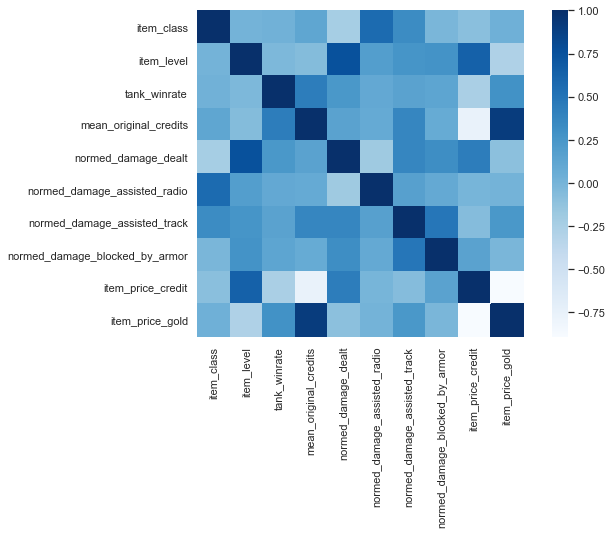

item_price_credit                -0.890630
item_level                       -0.282797
normed_damage_dealt              -0.094682
normed_damage_blocked_by_armor   -0.013266
normed_damage_assisted_radio      0.010422
item_class                        0.039370
normed_damage_assisted_track      0.243434
tank_winrate                      0.289852
mean_original_credits             0.911362
item_price_gold                   1.000000
Name: item_price_gold, dtype: float64

In [39]:
corr = dataset.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [40]:
res_data = dataset.groupby('vehicle_type_cd').mean().reset_index()
tank_params = res_data[res_data['vehicle_type_cd'] == 9217]
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

res_data.drop(columns=['vehicle_type_cd'], inplace=True, axis=1)

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

,item_class,item_level,tank_winrate,mean_original_credits,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,4,8,0.504088,51220.040495,479.959688,219.826829,40.741581,230.241584,7500
1,4,6,0.493056,21582.319444,227.203591,119.428428,15.850074,71.171927,3650
2,3,7,0.518851,33862.425736,289.987615,308.394343,20.457760,11.882486,4800
3,2,8,0.506536,46795.680606,499.066434,189.746591,39.402811,410.436373,12250
4,2,8,0.521193,52728.084989,606.301366,159.702848,34.139702,393.939500,10700
...,...,...,...,...,...,...,...,...,...
80,2,8,0.504362,45455.173292,480.083281,176.867489,39.023648,111.012978,11900
81,4,8,0.474610,40430.156189,404.101210,189.294783,31.075164,65.372967,8700
82,2,8,0.505074,46620.227286,473.663218,169.945646,33.925283,539.696188,10500
83,3,6,0.520567,25118.365412,238.777843,208.967774,10.759966,0.479820,3500


In [41]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,item_class,item_level,tank_winrate,mean_original_credits,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,1.047570,0.497419,0.047485,0.951285,0.096381,0.694756,0.767963,0.146570,-0.309826
1,1.047570,-2.230361,-0.452363,-1.874484,-1.575753,-0.854428,-1.388119,-0.704428,-1.489608
2,0.362620,-0.866471,0.716332,-0.703654,-1.160399,2.061386,-0.989005,-1.021617,-1.137206
3,-0.322329,0.497419,0.158364,0.529451,0.222783,0.230607,0.652000,1.110583,1.145750
4,-0.322329,0.497419,0.822444,1.095068,0.932207,-0.232979,0.196114,1.022328,0.670773
...,...,...,...,...,...,...,...,...,...
80,-0.322329,0.497419,0.059879,0.401642,0.097198,0.031878,0.619157,-0.491284,1.038497
81,1.047570,0.497419,-1.288056,-0.077462,-0.405469,0.223636,-0.069334,-0.735451,0.057899
82,-0.322329,0.497419,0.092139,0.512722,0.054726,-0.074929,0.177541,1.802103,0.609485
83,0.362620,-2.230361,0.794096,-1.537345,-1.499183,0.527197,-1.829021,-1.082619,-1.535574


In [42]:
train_data = np.array(normed_gold_dataset.drop(columns=['item_price_gold']))
train_labels = np.array(normed_gold_dataset[['item_price_gold']])

In [43]:
epochs = 200

model = build_network(train_data.shape[1])
history = model.fit(train_data, train_labels,
                    validation_split=0.15,
                    epochs=epochs, shuffle=True)

Train on 72 samples, validate on 13 samples
Epoch 1/200
72/72 [==============================] - 2s 25ms/sample - loss: 1.0977 - val_loss: 0.4362
Epoch 2/200
72/72 [==============================] - 0s 291us/sample - loss: 0.6928 - val_loss: 0.3553
Epoch 3/200
72/72 [==============================] - 0s 264us/sample - loss: 0.6876 - val_loss: 0.2791
Epoch 4/200
72/72 [==============================] - 0s 235us/sample - loss: 0.4495 - val_loss: 0.2314
Epoch 5/200
72/72 [==============================] - 0s 222us/sample - loss: 0.4035 - val_loss: 0.2009
Epoch 6/200
72/72 [==============================] - 0s 235us/sample - loss: 0.4070 - val_loss: 0.1800
Epoch 7/200
72/72 [==============================] - 0s 249us/sample - loss: 0.3483 - val_loss: 0.1674
Epoch 8/200
72/72 [==============================] - 0s 249us/sample - loss: 0.2697 - val_loss: 0.1641
Epoch 9/200
72/72 [==============================] - 0s 235us/sample - loss: 0.2361 - val_loss: 0.1600
Epoch 10/200
72/72 [==========

72/72 [==============================] - 0s 235us/sample - loss: 0.0527 - val_loss: 0.1563
Epoch 80/200
72/72 [==============================] - 0s 222us/sample - loss: 0.0527 - val_loss: 0.1572
Epoch 81/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0683 - val_loss: 0.1565
Epoch 82/200
72/72 [==============================] - 0s 263us/sample - loss: 0.0544 - val_loss: 0.1505
Epoch 83/200
72/72 [==============================] - 0s 291us/sample - loss: 0.0414 - val_loss: 0.1524
Epoch 84/200
72/72 [==============================] - 0s 222us/sample - loss: 0.0341 - val_loss: 0.1646
Epoch 85/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0663 - val_loss: 0.1584
Epoch 86/200
72/72 [==============================] - ETA: 0s - loss: 0.022 - 0s 263us/sample - loss: 0.0523 - val_loss: 0.1566
Epoch 87/200
72/72 [==============================] - 0s 249us/sample - loss: 0.0353 - val_loss: 0.1532
Epoch 88/200
72/72 [==============================] -

72/72 [==============================] - 0s 235us/sample - loss: 0.0194 - val_loss: 0.1390
Epoch 158/200
72/72 [==============================] - 0s 249us/sample - loss: 0.0246 - val_loss: 0.1377
Epoch 159/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0275 - val_loss: 0.1413
Epoch 160/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0272 - val_loss: 0.1383
Epoch 161/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0380 - val_loss: 0.1268
Epoch 162/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0255 - val_loss: 0.1309
Epoch 163/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0192 - val_loss: 0.1302
Epoch 164/200
72/72 [==============================] - 0s 235us/sample - loss: 0.0451 - val_loss: 0.1382
Epoch 165/200
72/72 [==============================] - 0s 249us/sample - loss: 0.0441 - val_loss: 0.1384
Epoch 166/200
72/72 [==============================] - 0s 235us/sampl

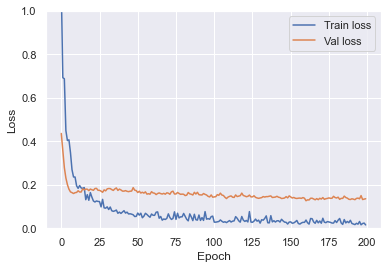

In [44]:
plot_network_history(history)

In [45]:
full_model = build_network(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=epochs, shuffle=True)

Train on 85 samples
Epoch 1/200
85/85 [==============================] - 1s 7ms/sample - loss: 0.9936
Epoch 2/200
85/85 [==============================] - 0s 94us/sample - loss: 0.5732
Epoch 3/200
85/85 [==============================] - 0s 82us/sample - loss: 0.5208
Epoch 4/200
85/85 [==============================] - 0s 94us/sample - loss: 0.4336
Epoch 5/200
85/85 [==============================] - 0s 94us/sample - loss: 0.2920
Epoch 6/200
85/85 [==============================] - 0s 82us/sample - loss: 0.3036
Epoch 7/200
85/85 [==============================] - 0s 106us/sample - loss: 0.3248
Epoch 8/200
85/85 [==============================] - 0s 94us/sample - loss: 0.2280
Epoch 9/200
85/85 [==============================] - 0s 106us/sample - loss: 0.2800
Epoch 10/200
85/85 [==============================] - 0s 82us/sample - loss: 0.2497
Epoch 11/200
85/85 [==============================] - 0s 106us/sample - loss: 0.1874
Epoch 12/200
85/85 [==============================] - 0s 94us/s

85/85 [==============================] - 0s 117us/sample - loss: 0.0384
Epoch 98/200
85/85 [==============================] - 0s 94us/sample - loss: 0.0445
Epoch 99/200
85/85 [==============================] - 0s 106us/sample - loss: 0.0421
Epoch 100/200
85/85 [==============================] - 0s 117us/sample - loss: 0.0293
Epoch 101/200
85/85 [==============================] - 0s 117us/sample - loss: 0.0424
Epoch 102/200
85/85 [==============================] - 0s 82us/sample - loss: 0.0371
Epoch 103/200
85/85 [==============================] - 0s 106us/sample - loss: 0.0421
Epoch 104/200
85/85 [==============================] - 0s 94us/sample - loss: 0.0371
Epoch 105/200
85/85 [==============================] - 0s 94us/sample - loss: 0.0259
Epoch 106/200
85/85 [==============================] - 0s 117us/sample - loss: 0.0289
Epoch 107/200
85/85 [==============================] - 0s 82us/sample - loss: 0.0353
Epoch 108/200
85/85 [==============================] - 0s 94us/sample - los

85/85 [==============================] - 0s 94us/sample - loss: 0.0639
Epoch 193/200
85/85 [==============================] - 0s 106us/sample - loss: 0.0268
Epoch 194/200
85/85 [==============================] - 0s 117us/sample - loss: 0.0249
Epoch 195/200
85/85 [==============================] - 0s 106us/sample - loss: 0.0227
Epoch 196/200
85/85 [==============================] - 0s 94us/sample - loss: 0.0268
Epoch 197/200
85/85 [==============================] - 0s 117us/sample - loss: 0.0348
Epoch 198/200
85/85 [==============================] - 0s 82us/sample - loss: 0.0204
Epoch 199/200
85/85 [==============================] - 0s 106us/sample - loss: 0.0239
Epoch 200/200
85/85 [==============================] - 0s 94us/sample - loss: 0.0273


In [46]:
tank_params.drop(columns=['vehicle_type_cd', 'item_price_credit', 'item_price_gold'], inplace=True, axis=1)
tank_params

,item_class,item_level,tank_winrate,mean_original_credits,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
125,2,8,0.495916,42733.951302,484.070477,156.699486,38.351904,418.718339


In [47]:
def predict(tank_params):
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    
    pred_full = full_model.predict(scaled)
    pred = model.predict(scaled)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x = np.concatenate((scaled[0], pred[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x)[-1]

predict(tank_params)

(11876.295110378578, 11428.78812264307)

# Tests

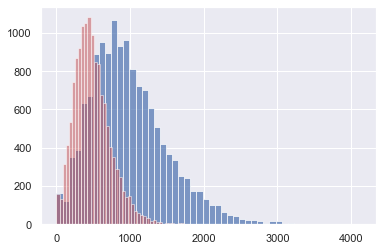

In [48]:
damage = arena_members[arena_members['vehicle_type_cd'] == 9217][['account_db_id', 'damage_dealt', 'player_winrate_ML']]
damage = damage[damage.groupby('account_db_id')['account_db_id'].transform('count') >= 2]

pl = damage.groupby('account_db_id').agg({'damage_dealt' : lambda g: g.mean(),
                                          'player_winrate_ML' : 'mean'})
pl['normed'] = (1 - pl['player_winrate_ML']) * pl['damage_dealt']

plt.hist(pl['damage_dealt'], bins=50, alpha=0.7)
plt.hist(pl['normed'], bins=50, color='r', alpha=0.5)
plt.show()